In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Lambda, concatenate, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import glob
from tqdm.notebook import tqdm, trange

#initialize GPUs    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-20 00:24:18.357279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 00:24:18.357381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 00:24:18.542552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2 Physical GPUs, 1 Logical GPU


# MRI Dataset

In [2]:
config = {
    'IMAGE_WIDTH':256,
    'IMAGE_HEIGHT':256,
    'NUM_CHANNELS':3
}

In [3]:
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

### categorizing datapoints with empty mask and non empty mask into seperate arrays

In [4]:
empty_masks = []
non_empty_masks = []

for mask_path in tqdm(mask_paths):
    mask = np.array(Image.open(mask_path))
    if (mask == 0).all():
        empty_masks.append(mask_path)
    else:
        non_empty_masks.append(mask_path)

  0%|          | 0/3929 [00:00<?, ?it/s]

### select all datapoints with non empty mask and 200 with empty mask datapoint for train

In [5]:
masks_paths = non_empty_masks + [empty_masks[idx] for idx in np.random.choice(len(empty_masks), 200)]
image_paths = [mask_path.replace('_mask', '') for mask_path in mask_paths]

path_df = pd.DataFrame({'image':image_paths, 'mask':mask_paths})

In [6]:
len(non_empty_masks)

1373

### preparing dataloader

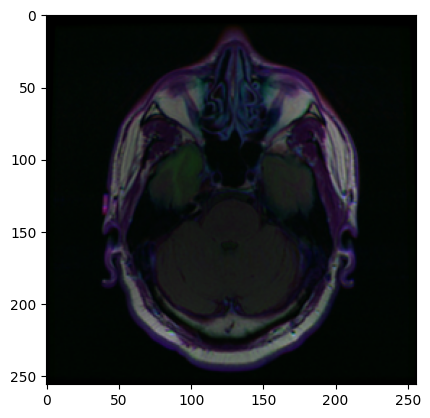

In [7]:
class MRIDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.df) // self.batch_size
    
    def get_image(self, path):
        image = Image.open(path)
        image = np.array(image).astype(np.float32) / 255
        image = resize(image, (config['IMAGE_HEIGHT'], config['IMAGE_WIDTH']), mode='constant', preserve_range=True)        
        return image
    
    def get_mask(self, path):
        mask = Image.open(path)
        mask = np.array(mask).astype(np.bool_)
        mask = resize(mask, (config['IMAGE_HEIGHT'], config['IMAGE_WIDTH']), mode='constant', preserve_range=True)
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        return mask
    
    def __getitem__(self, idx):
        batch = self.df[idx*self.batch_size:(idx+1)*self.batch_size]
        images = []
        masks = []
        
        for _, (image_path, mask_path) in batch.iterrows():
            images.append(self.get_image(image_path))
            masks.append(self.get_mask(mask_path))
            
        images = np.array(images)
        masks = np.array(masks)
        
        return images, masks
    
dataset = MRIDataset(path_df, 1)
image, mask = dataset[200]
plt.imshow(image[0])
            
    

### train test val split

In [11]:
from sklearn.model_selection import train_test_split

train, test_val = train_test_split(path_df, test_size=0.4)
test, val = train_test_split(test_val, test_size=0.25)
train = MRIDataset(train, 32)
test = MRIDataset(test, 32)
val = MRIDataset(val, 32)

### define loss functions (dice_loss, jaccard_loss) 

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    
    dice_coef = (2*intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    return dice_coef

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    
    jaccard_coef = (intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1)
    return jaccard_coef

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jaccard_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)


# Simple U-Net

In [13]:
def build_model():
    inputs = Input((config['IMAGE_WIDTH'], config['IMAGE_HEIGHT'], config['NUM_CHANNELS']))
    scaled = Lambda(lambda x: x /255)(inputs)
    
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(scaled)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = Dropout(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = Dropout(0.2)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = Dropout(0.2)(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6) 
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)     
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8) 
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

EPOCHS = 30
lr = 1e-3
# decay_rate = lr/EPOCHS 

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_13[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_15[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_17[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ dropout_18[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

# Res-U-Net

In [32]:
def build_model():
    inputs = Input((config['IMAGE_WIDTH'], config['IMAGE_HEIGHT'], config['NUM_CHANNELS']))
    scaled = Lambda(lambda x: x /255)(inputs)
    
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(scaled)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = Dropout(0.1)(c1)
    res = Conv2D(16, (1,1), padding='same')(scaled)
    c1 = add([c1, res])
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = Dropout(0.1)(c2)
    res = Conv2D(32, (1,1), padding='same')(p1)
    c2 = add([c2, res])    
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = Dropout(0.2)(c3)
    res = Conv2D(64, (1,1), padding='same')(p2)
    c3 = add([c3, res])    
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = Dropout(0.2)(c4)
    res = Conv2D(128, (1,1), padding='same')(p3)
    c4 = add([c4, res])    
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    u6 = Conv2D(128, (1, 1), padding='same')(u6)
    c6 = add([u6, c6])
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)     
    u7 = Conv2D(64, (1, 1), padding='same')(u7)
    c7 = add([u7, c7])    
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8) 
    u8 = Conv2D(32, (1, 1), padding='same')(u8)
    c8 = add([u8, c8])
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    u9 = Conv2D(16, (1, 1), padding='same')(u9)
    c9 = add([u9, c9])
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

EPOCHS = 30
lr = 1e-3
# decay_rate = lr/EPOCHS 

res_model = build_model()
res_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[dice_coef])
res_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 256, 256,  │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_26[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256, 256,  │          0 │ conv2d_39[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 256, 256,  │         64 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ dropout_27[0][0], │
│                     │ 16)               │            │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128, 128,  │          0 │ conv2d_41[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128, 128,  │          0 │ conv2d_42[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ dropout_29[0][0], │
│                     │ 32)               │            │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[

 Total params: 1,995,905 (7.61 MB)

 Trainable params: 1,995,905 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training

### training UNet

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_mri.keras', verbose=1, save_best_only=True)

callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=callbacks)

### train res-U-Net

In [34]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('res_model_for_mri.keras', verbose=1, save_best_only=True)

callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = res_model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - dice_coef: 0.0125 - loss: 0.2087
Epoch 1: val_loss improved from inf to 0.08682, saving model to res_model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 109s 864ms/step - dice_coef: 0.0126 - loss: 0.2072 - val_dice_coef: 0.0288 - val_loss: 0.0868
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - dice_coef: 0.0307 - loss: 0.0501
Epoch 2: val_loss improved from 0.08682 to 0.04112, saving model to res_model_for_mri.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 840ms/step - dice_coef: 0.0308 - loss: 0.0500 - val_dice_coef: 0.0571 - val_loss: 0.0411
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - dice_coef: 0.0861 - loss: 0.0418
Epoch 3: val_loss did not improve from 0.04112
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 848ms/step - dice_coef: 0.0863 - loss: 0.0418 - val_dice_coef: 0.0895 - val_loss: 0.0429
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - dice_coef: 0.1661 - loss: 0.0343
Epoch 4: val_loss did not improve from 0.04112
73/73 ━━━━━━━━━━━

# Plotting predictions

### predicting for 10 selected test images from UNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


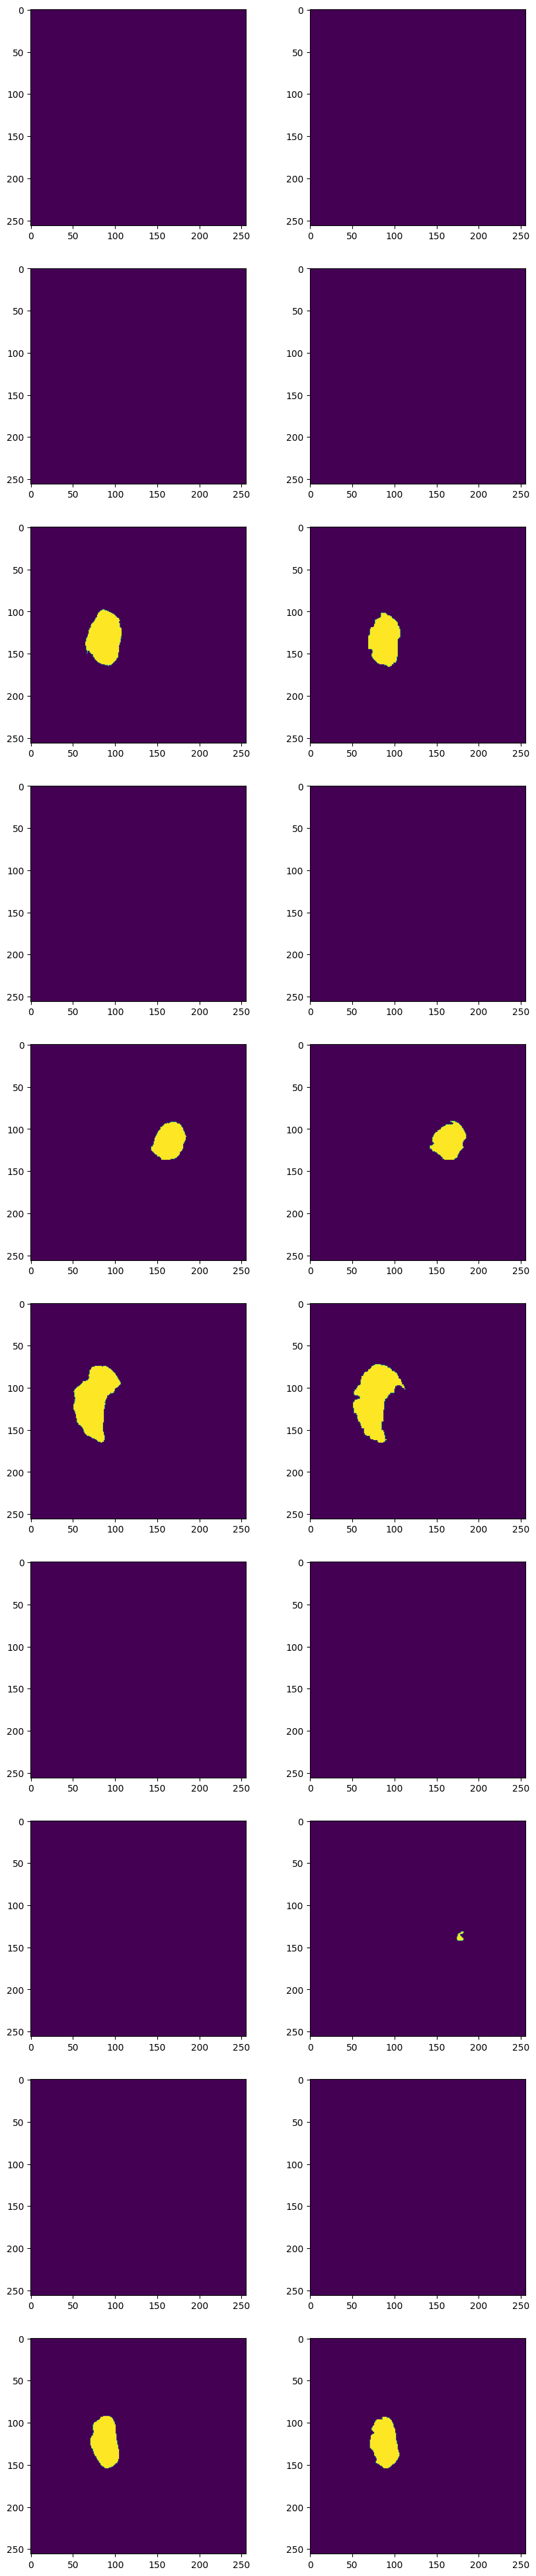

In [43]:
model.load_weights('/kaggle/working/model_for_mri.keras')

i = 10
image, mask = test[i]
pred = res_model.predict(image)

plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(pred[i] > .5)
    plt.subplot(10, 2, i*2+2)
    plt.imshow(mask[i])
plt.show()

### predicting for 10 selected test images from res-UNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


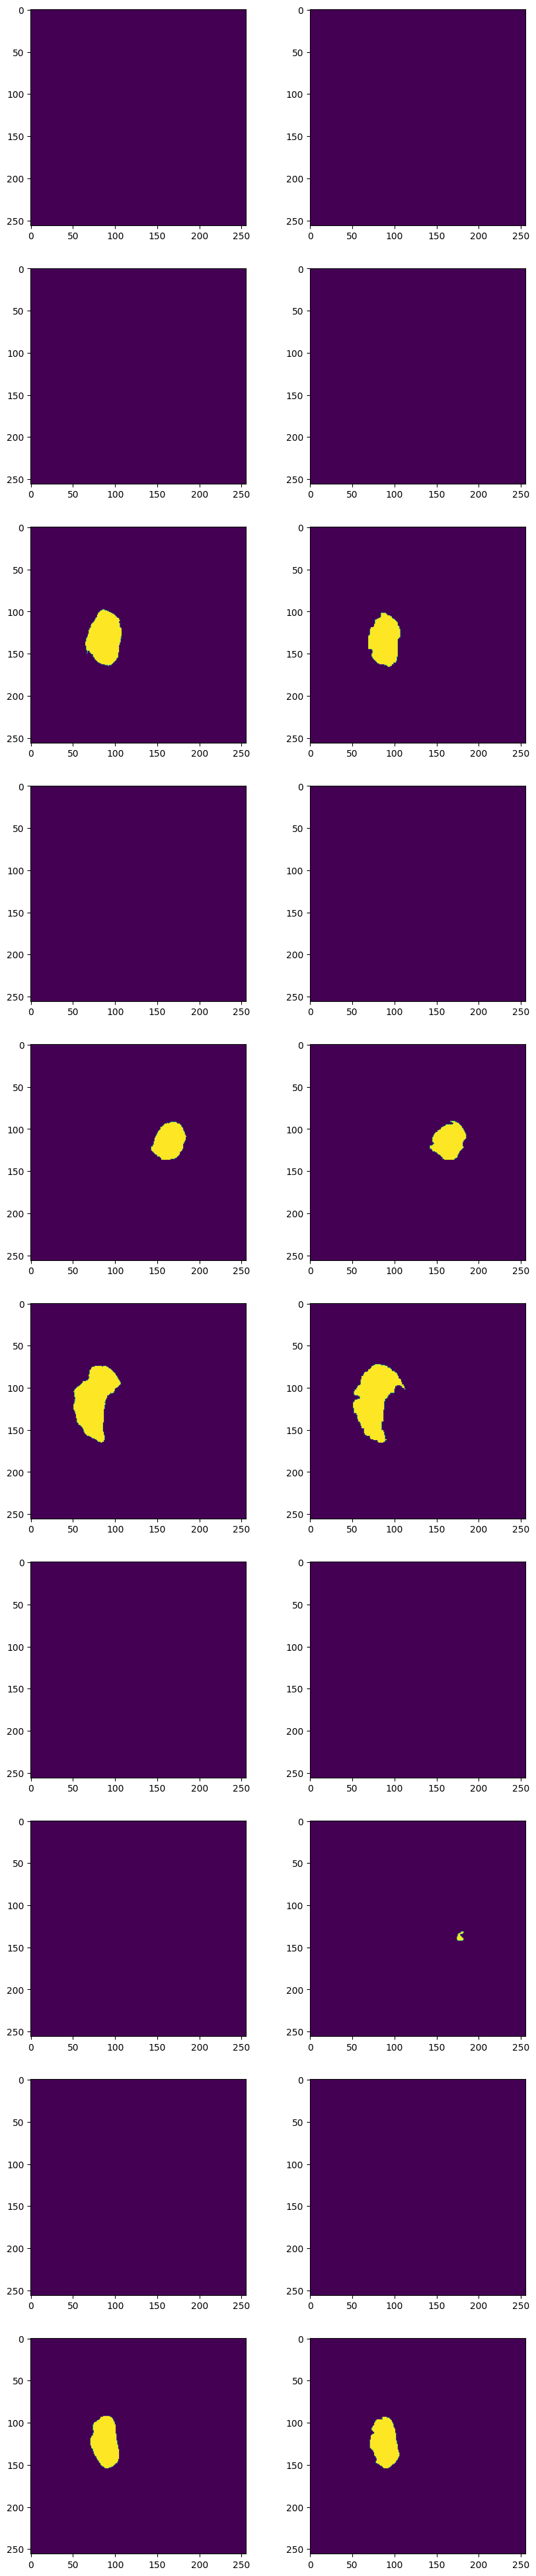

In [42]:
res_model.load_weights('/kaggle/working/res_model_for_mri.keras')

i = 10
image, mask = test[i]
pred = res_model.predict(image)

plt.subplots(10, 2, figsize=(10, 50))
for i in range(10):
    plt.subplot(10, 2, i*2+1)
    plt.imshow(pred[i] > .5)
    plt.subplot(10, 2, i*2+2)
    plt.imshow(mask[i])
plt.show()